In [43]:
#imports
import numpy as np
import pandas as pd
import lasio 
from las_py import Laspy
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [4]:
las = lasio.read("./data/100163203803W400.las")
mnemonic = las.keys()
print(mnemonic)

['DEPTH', 'GR', 'NPHI', 'PE', 'RHOB', 'AC']


In [5]:
data = np.loadtxt('./data/100163203803W400.las', skiprows=52)

data = pd.DataFrame(data, columns=mnemonic)

data.head(10)

,DEPTH,GR,NPHI,PE,RHOB,AC
0,770.80,68.87,0.430,0.99,1.916,384.91
1,770.84,68.38,0.399,1.00,2.041,376.11
2,770.88,65.32,0.358,1.16,2.192,366.95
3,770.92,65.47,0.333,1.50,2.323,358.01
4,770.96,66.36,0.313,1.92,2.367,349.87
5,771.00,65.03,0.298,2.13,2.359,342.99
6,771.04,66.45,0.293,2.20,2.338,337.69
7,771.08,68.83,0.298,2.33,2.314,334.15
8,771.12,67.63,0.295,2.38,2.310,332.33
9,771.16,67.57,0.296,2.29,2.321,331.98


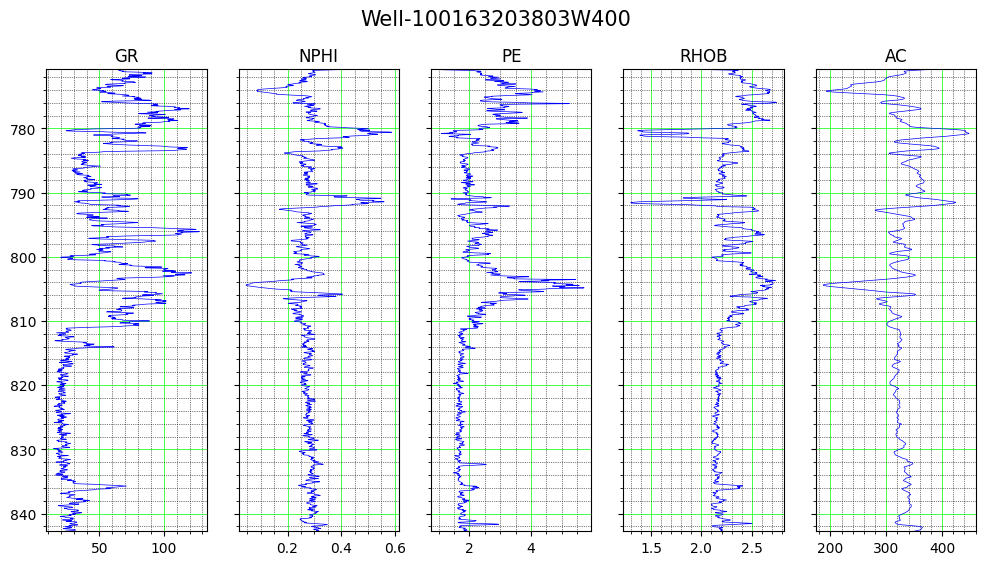

In [19]:
logs = data.columns[1:]
rows,cols = 1,5
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6), sharey=True)

plt.suptitle('Well-100163203803W400', size=15)
for i in range(cols):
    ax[i].plot(data[logs[i]], data.DEPTH, color='b', lw=0.5)
    ax[i].set_title('%s' % logs[i])
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='-', linewidth='0.5', color='lime')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax[i].set_ylim(max(data.DEPTH), min(data.DEPTH))

In [46]:
x = data.iloc[:,1:3]
print(x)

         GR   NPHI
0     68.87  0.430
1     68.38  0.399
2     65.32  0.358
3     65.47  0.333
4     66.36  0.313
...     ...    ...
1795  30.75  0.315
1796  30.16  0.308
1797  27.49  0.311
1798  24.19  0.317
1799  23.51  0.321

[1800 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


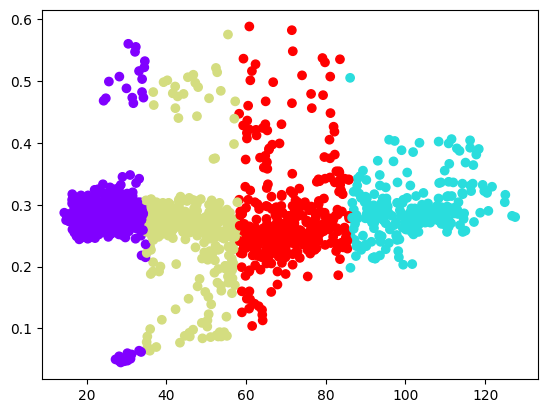

In [48]:
kmeans = KMeans(4)
kmeans.fit(x)
identified_clusters = kmeans.fit_predict(x)
data_with_clusters = data.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['GR'],data_with_clusters['NPHI'],c=data_with_clusters['Clusters'],cmap='rainbow')

In [37]:
test = KMeans(3)
test.fit(data)

predicted_labels = test.predict(data)
for i, label in enumerate(predicted_labels):
    print(f"Sample {i+1}: Lithology Cluster {label+1}")

Sample 1: Lithology Cluster 2
Sample 2: Lithology Cluster 2
Sample 3: Lithology Cluster 2
Sample 4: Lithology Cluster 2
Sample 5: Lithology Cluster 2
Sample 6: Lithology Cluster 2
Sample 7: Lithology Cluster 2
Sample 8: Lithology Cluster 2
Sample 9: Lithology Cluster 2
Sample 10: Lithology Cluster 2
Sample 11: Lithology Cluster 2
Sample 12: Lithology Cluster 2
Sample 13: Lithology Cluster 2
Sample 14: Lithology Cluster 2
Sample 15: Lithology Cluster 2
Sample 16: Lithology Cluster 2
Sample 17: Lithology Cluster 2
Sample 18: Lithology Cluster 2
Sample 19: Lithology Cluster 2
Sample 20: Lithology Cluster 2
Sample 21: Lithology Cluster 2
Sample 22: Lithology Cluster 2
Sample 23: Lithology Cluster 1
Sample 24: Lithology Cluster 1
Sample 25: Lithology Cluster 1
Sample 26: Lithology Cluster 1
Sample 27: Lithology Cluster 1
Sample 28: Lithology Cluster 1
Sample 29: Lithology Cluster 1
Sample 30: Lithology Cluster 1
Sample 31: Lithology Cluster 1
Sample 32: Lithology Cluster 1
Sample 33: Lithol

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
